In [1]:
%matplotlib inline
#%pylab
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import matplotlib.dates as dts
import numpy as np
import pandas as pd
import itertools
import os
import ROOT
import datetime
from root_numpy import root2array, root2rec, tree2rec, array2root
from scipy.optimize import curve_fit
from scipy.misc import factorial
import scipy
plt.rcParams.update({'font.size': 16})

In [2]:
from decode import GetWaveforms

In [3]:
from datetime import datetime

In [4]:
def gettime(name):
    date = name.split('PrM1-')[-1].split('.dat')[0]
    time = datetime.strptime(date,'%Y_%m_%d-%H_%M_%S')
    return time

In [5]:
def QaQc(wf_v):
    anode_v = wf_v[0][700:]
    cathode_v = wf_v[1][500:]
    Qa = np.amax(anode_v)
    Qc = np.amin(cathode_v)
    return Qa,Qc

def QaQcSTATS(ev_wf_v):
    
    Qa_v = []
    Qc_v = []
    for wf_v in ev_wf_v:
        Qa,Qc = QaQc(wf_v)
        Qa_v.append(Qa*1e3)
        Qc_v.append(Qc*1e3)
    Qa_v = np.array(Qa_v)
    Qc_v = np.array(Qc_v)

    Qa_avg = np.mean(Qa_v)
    Qa_rms = np.std(Qa_v)
    Qc_avg = np.mean(Qc_v)
    Qc_rms = np.std(Qc_v)
    
    return [[Qa_avg,Qa_rms],[Qc_avg,Qc_rms]]

In [6]:
PATH = '/home/david/Dropbox/Neutrinos/LArCADe/Run1/'
datafile_v = os.listdir(PATH)

In [7]:
datafile = PATH + datafile_v[0]
ev_wf_v = GetWaveforms(datafile)

In [8]:
dt = 0.0005

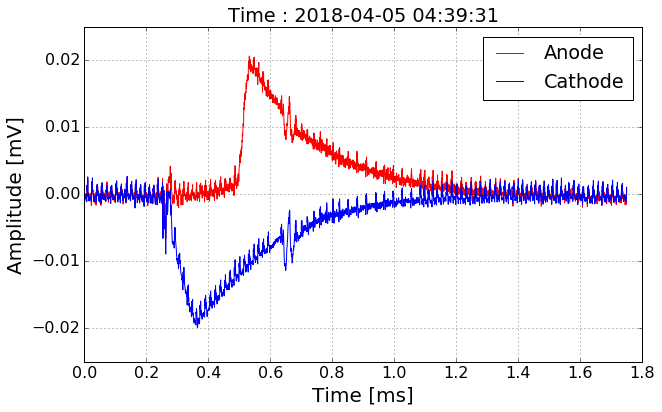

In [9]:
time = gettime(datafile_v[0])

n = 0
time_v = np.linspace(0,dt*len(ev_wf_v[n][0]),len(ev_wf_v[n][0]))

fig = plt.figure(figsize=(10,6))
plt.plot(time_v,ev_wf_v[n][0],color='r',label='Anode')
plt.plot(time_v,ev_wf_v[n][1],color='b',label='Cathode')
plt.grid()
plt.legend(loc=1)
plt.xlabel('Time [ms]',fontsize=20)
plt.ylabel('Amplitude [mV]',fontsize=20)
plt.title('Time : %s'%time)
plt.ylim([-0.025,0.025])
#plt.xlim([0,0.05])
plt.show()

In [10]:
avg_wf_anode   = np.zeros(3000)
avg_wf_cathode = np.zeros(3000)
for n in xrange(1,len(ev_wf_v)):
    anode_wf   = ev_wf_v[n][0]
    cathode_wf = ev_wf_v[n][1]
    # find start of this waveform
    anodestart = 0
    for i,V in enumerate(anode_wf):
        if (V > 0.02):
            anodestart = i
            break
    avg_wf_anode   += anode_wf[anodestart:anodestart+3000]
    avg_wf_cathode += cathode_wf[anodestart:anodestart+3000]
avg_wf_anode   /= len(ev_wf_v)-1
avg_wf_cathode /= len(ev_wf_v)-1

In [11]:
time = gettime(datafile_v[0])
time_v = np.linspace(0,dt*len(avg_wf_anode),len(avg_wf_anode))

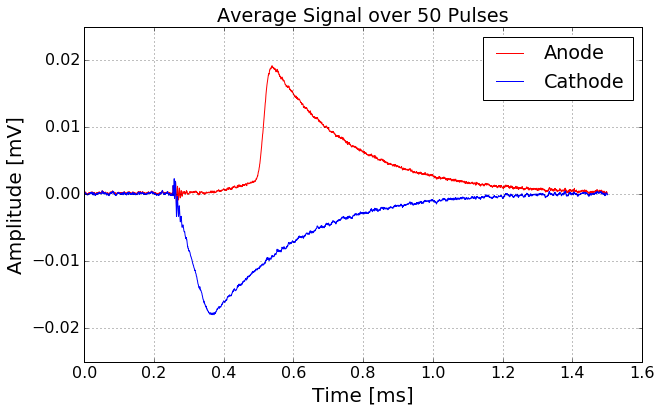

In [12]:
fig = plt.figure(figsize=(10,6))
plt.plot(time_v,avg_wf_anode  ,color='r',label='Anode')
plt.plot(time_v,avg_wf_cathode,color='b',label='Cathode')
plt.grid()
plt.legend(loc=1)
plt.xlabel('Time [ms]',fontsize=20)
plt.ylabel('Amplitude [mV]',fontsize=20)
plt.title('Average Signal over 50 Pulses')
plt.ylim([-0.025,0.025])
plt.show()

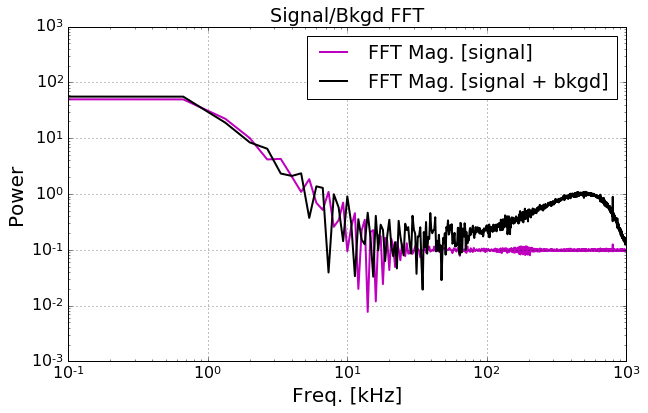

In [30]:
# fft of average
fft_a_v_avg = np.fft.fft(avg_wf_anode)
fft_c_v_avg = np.fft.fft(avg_wf_cathode)
fftmag_avg = np.abs(fft_a_v_avg)**2
# fft of a single event
fft_a_v_evt = np.fft.fft(ev_wf_v[n][0][:3000])
fft_c_v_evt = np.fft.fft(ev_wf_v[n][1][:3000])
fftmag_evt = np.abs(fft_a_v_evt)**2

freq_v = np.fft.fftfreq(3000,d=dt)

idx = np.argsort(freq_v)
freq_v = freq_v[idx]
fftmag_avg = fftmag_avg[idx]
fftmag_evt = fftmag_evt[idx]

fig = plt.figure(figsize=(10,6))
plt.plot(freq_v,fftmag_avg,lw=2,color='m',label='FFT Mag. [signal]')
plt.plot(freq_v,fftmag_evt,lw=2,color='k',label='FFT Mag. [signal + bkgd]')
plt.grid()
plt.legend(loc=1)
plt.xlabel('Freq. [kHz]',fontsize=20)
plt.ylabel('Power',fontsize=20)
plt.title('Signal/Bkgd FFT')
#plt.ylim([0.1,20])
plt.yscale('log')
plt.xscale('log')
#plt.xlim([0.3,0.8])
plt.show()

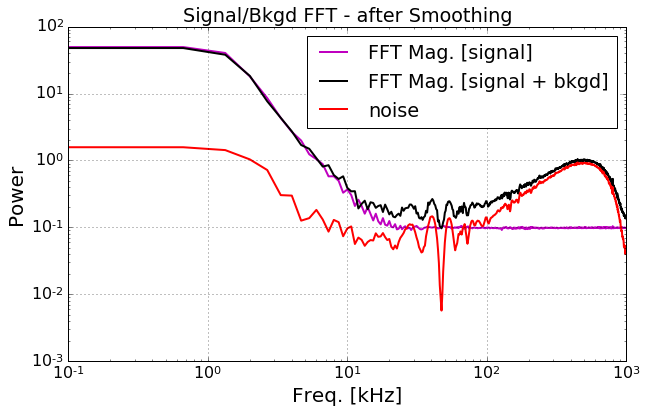

In [27]:
#smooth the frequencies
from scipy import signal as sgnl
# https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.savgol_filter.html
fftmag_avg_smooth = sgnl.savgol_filter(fftmag_avg,5,1)
fftmag_evt_smooth = sgnl.savgol_filter(fftmag_evt,5,1)

noise = fftmag_evt_smooth - fftmag_avg_smooth
noise = np.abs(noise)
noise = sgnl.savgol_filter(noise,5,1)


fig = plt.figure(figsize=(10,6))
plt.plot(freq_v,fftmag_avg_smooth,lw=2,color='m',label='FFT Mag. [signal]')
plt.plot(freq_v,fftmag_evt_smooth,lw=2,color='k',label='FFT Mag. [signal + bkgd]')
plt.plot(freq_v,noise            ,lw=2,color='r',label='noise')
plt.grid()
plt.legend(loc=1)
plt.xlabel('Freq. [kHz]',fontsize=20)
plt.ylabel('Power',fontsize=20)
plt.title('Signal/Bkgd FFT - after Smoothing')
#plt.ylim([0.1,20])
plt.yscale('log')
plt.xscale('log')
#plt.xlim([0.3,0.8])
plt.show()

In [57]:
# wiener signal filtering
# https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.wiener.html

/home/david/.local/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1501 but corresponding boolean dimension is 3000
/home/david/.local/lib/python2.7/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1501 but corresponding boolean dimension is 3000


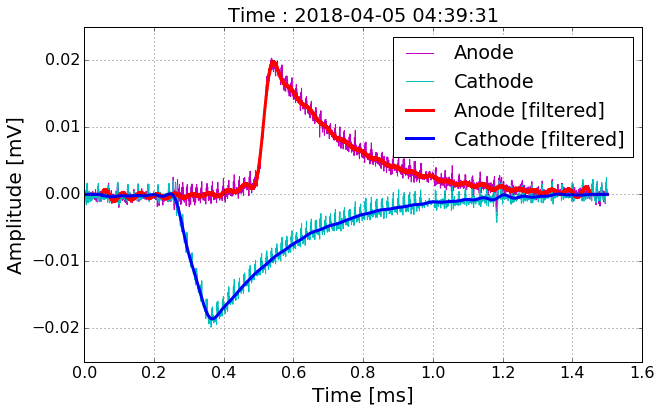

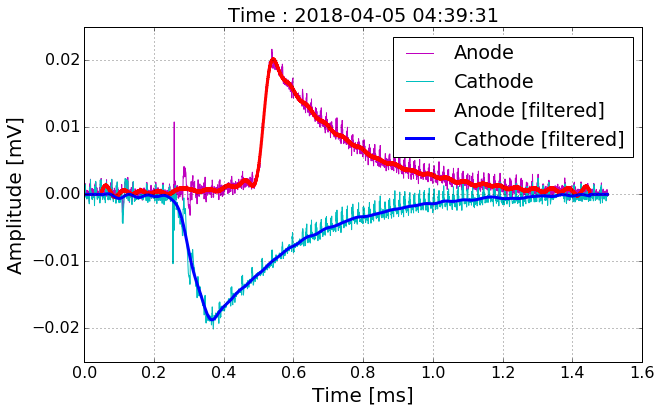

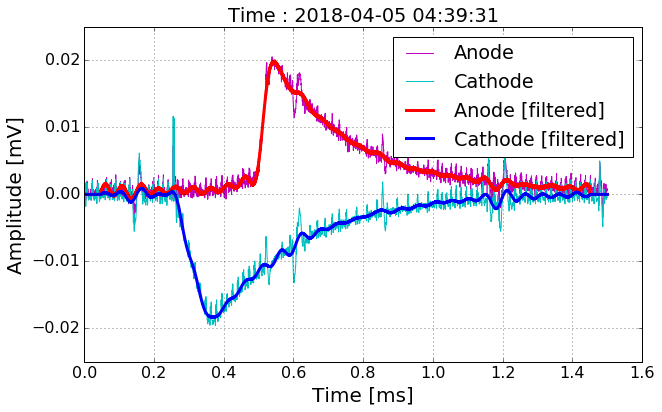

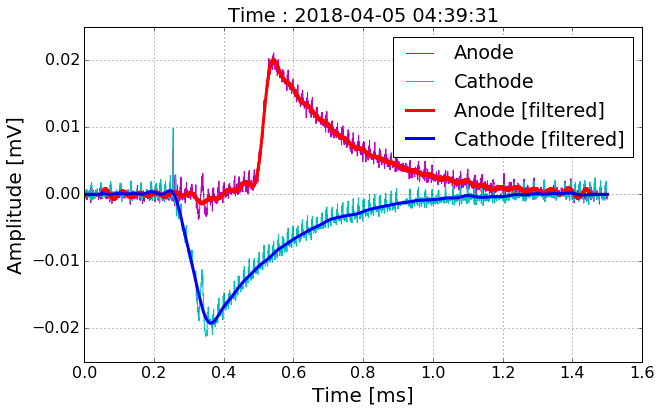

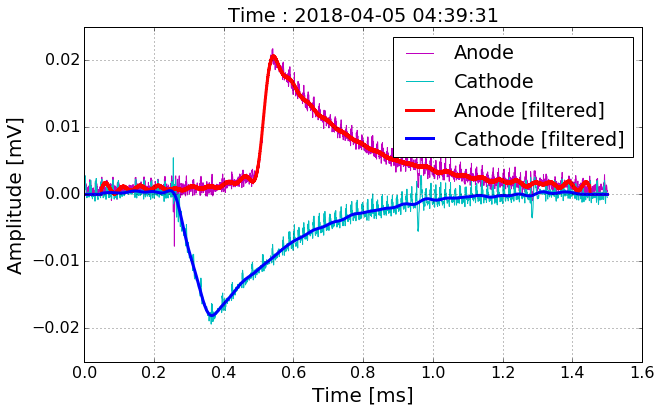

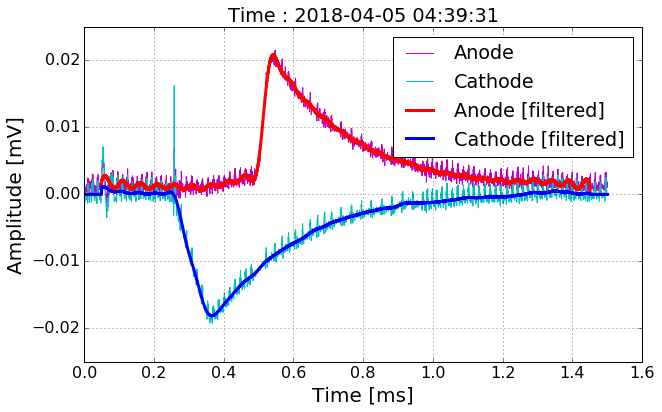

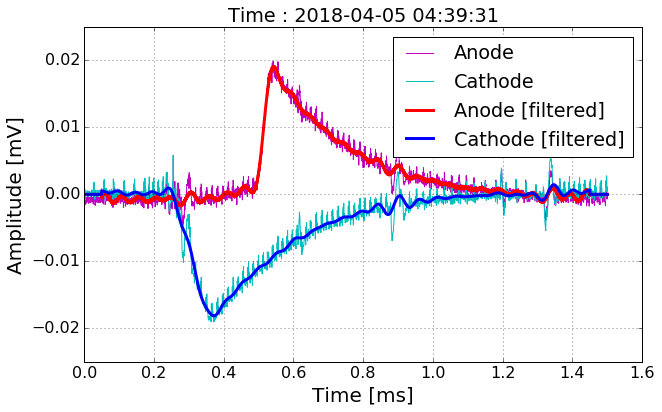

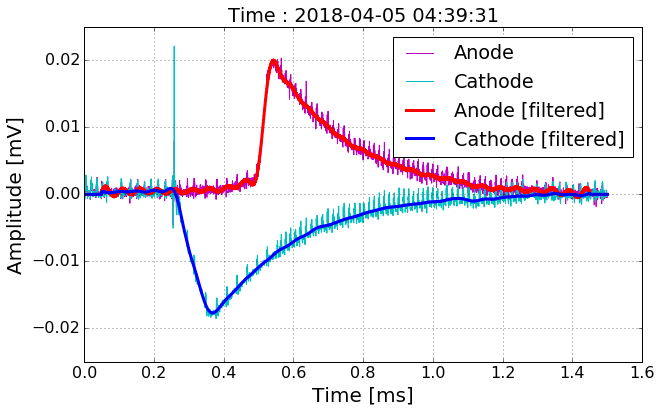

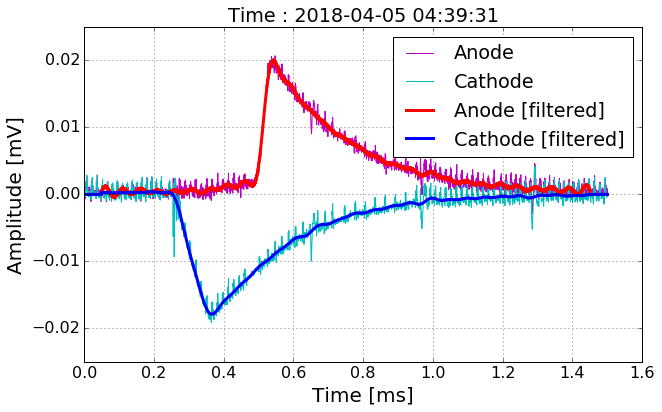

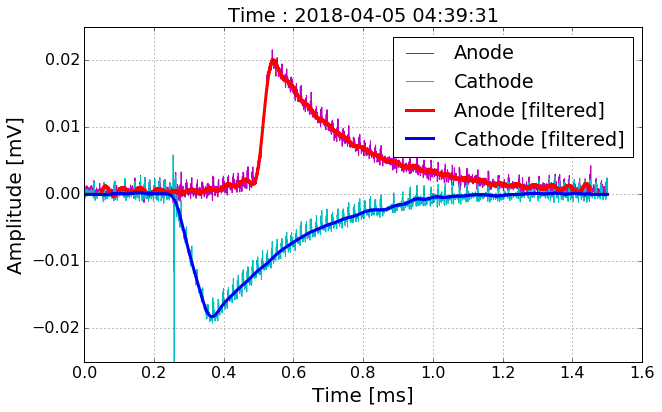

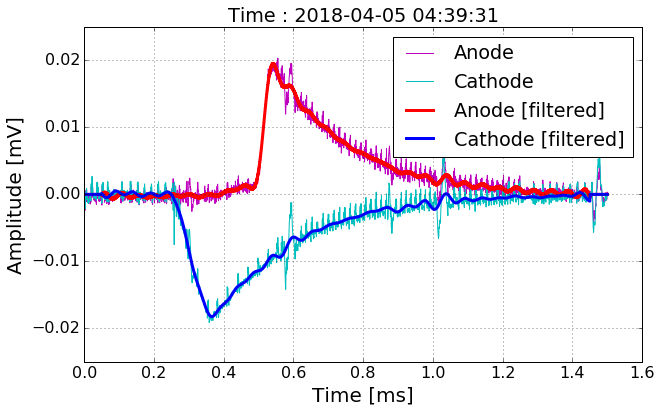

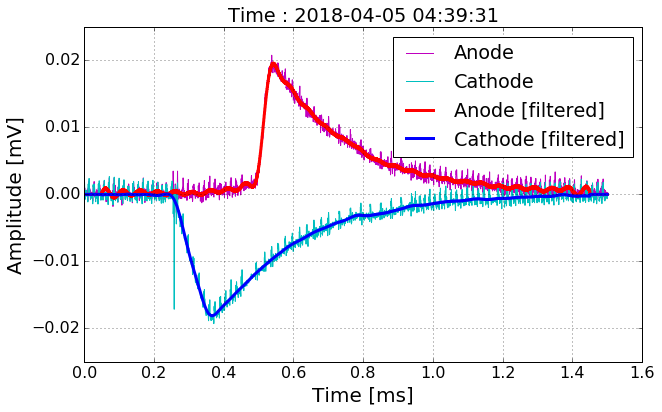

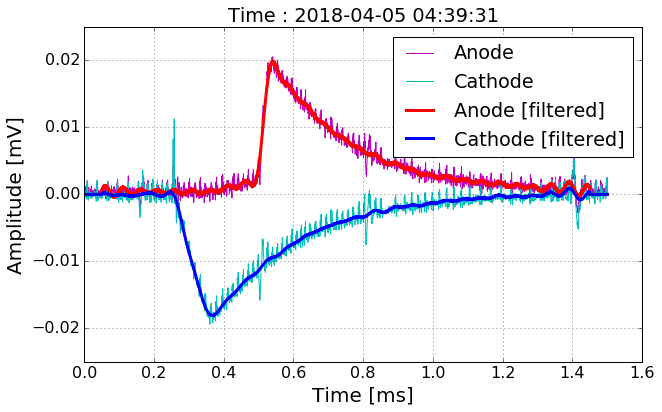

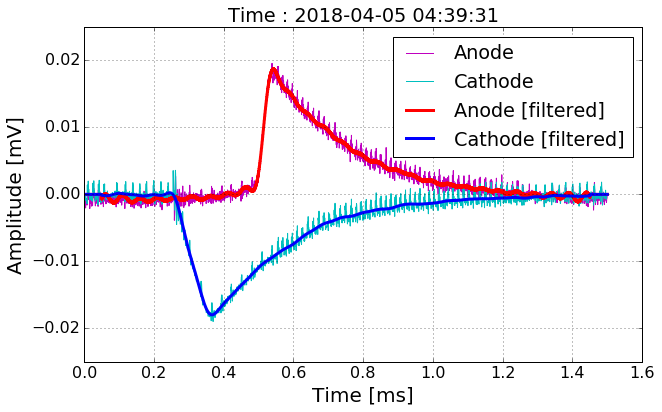

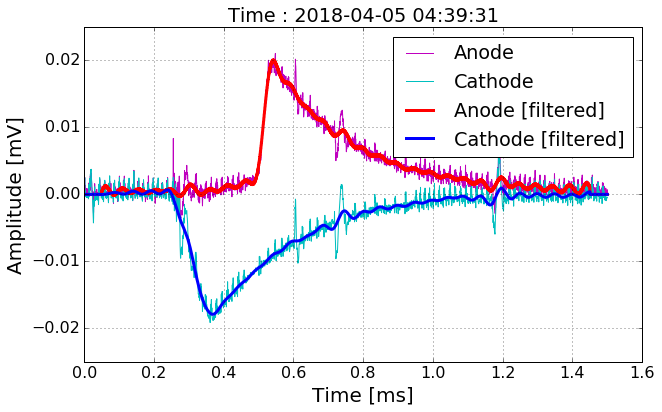

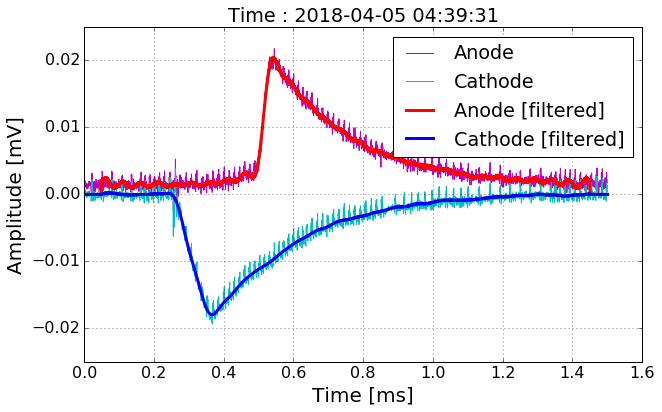

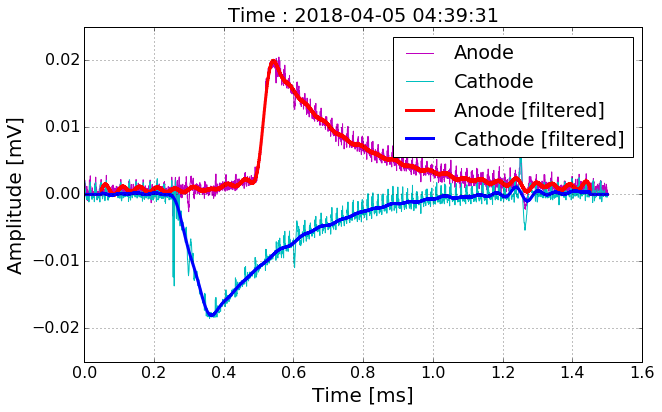

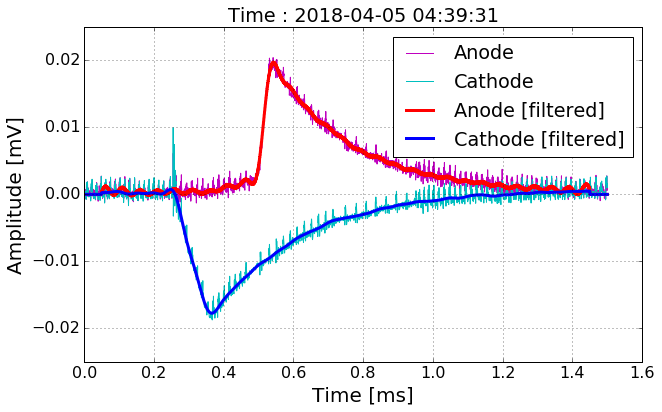

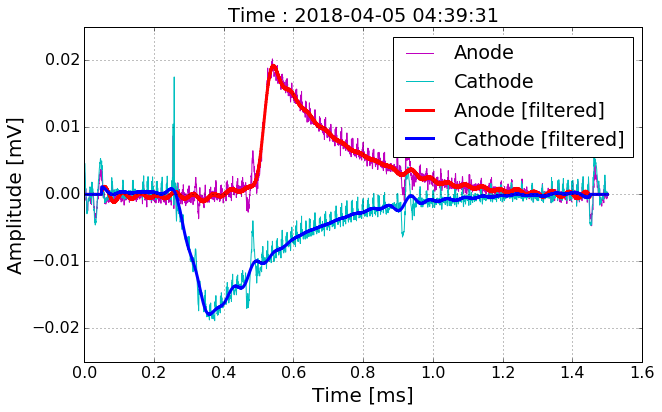

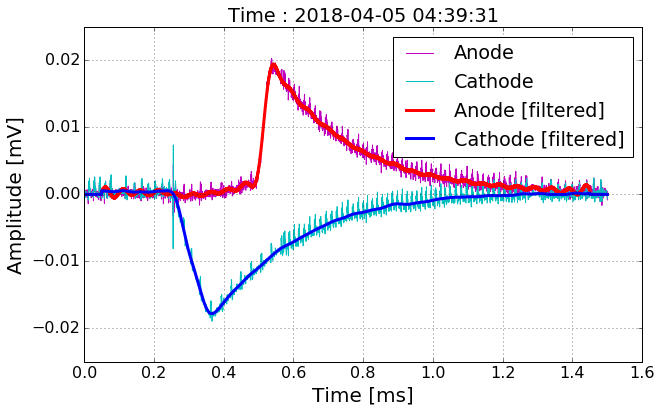

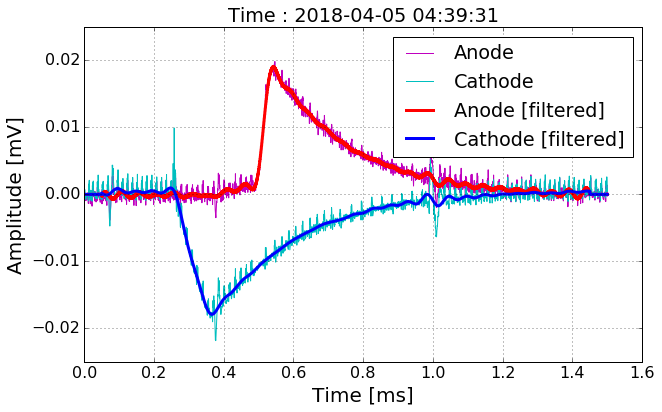

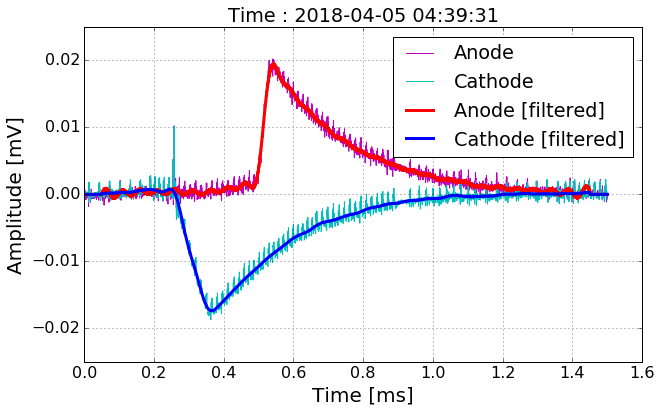

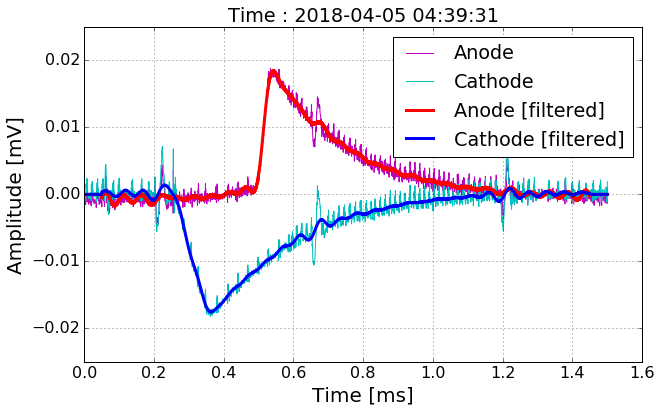

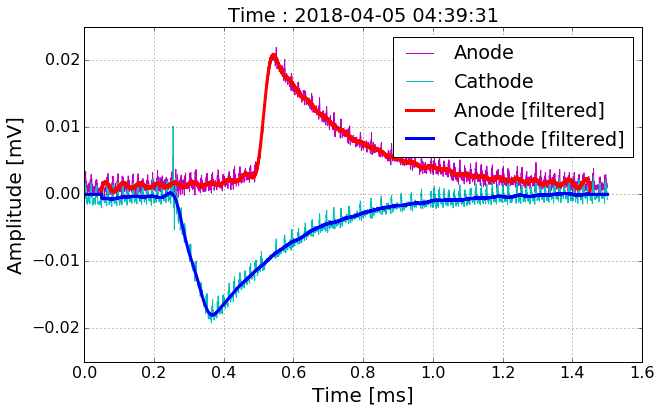

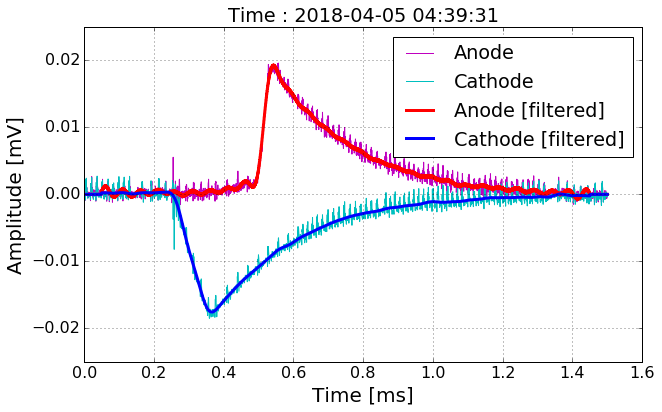

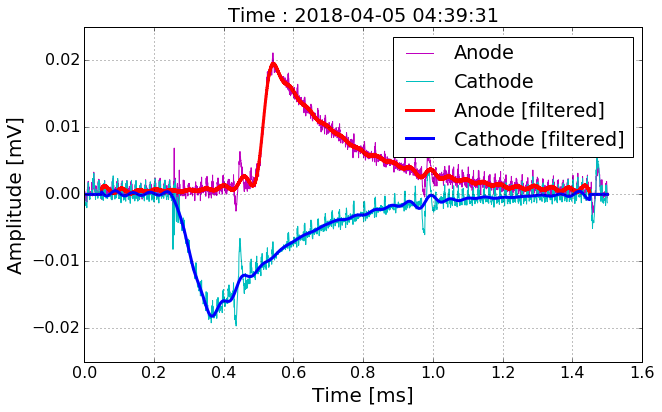

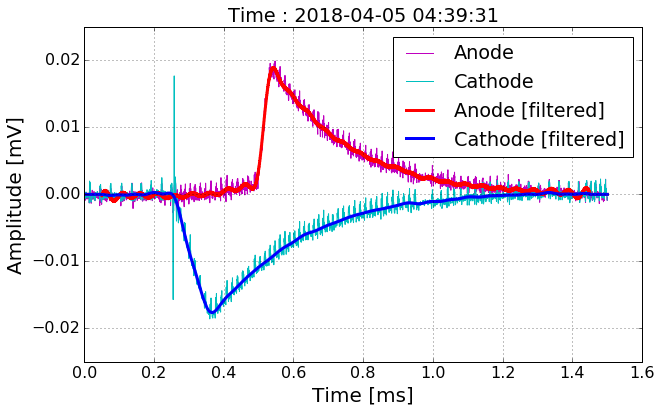

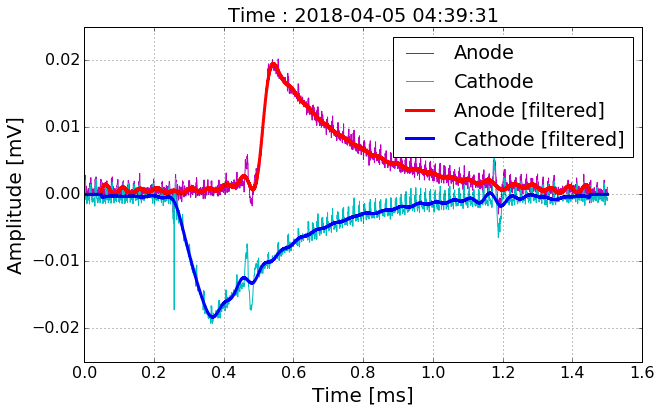

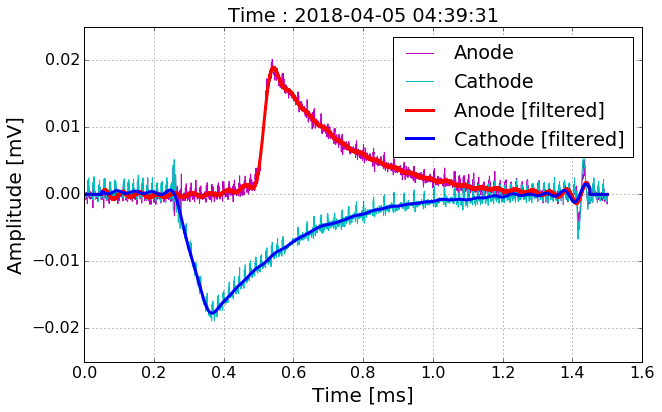

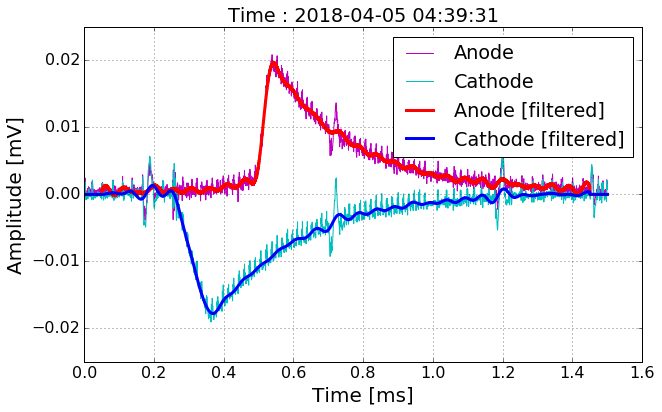

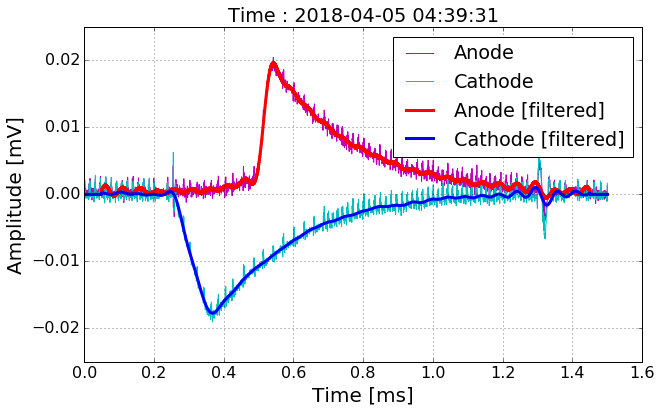

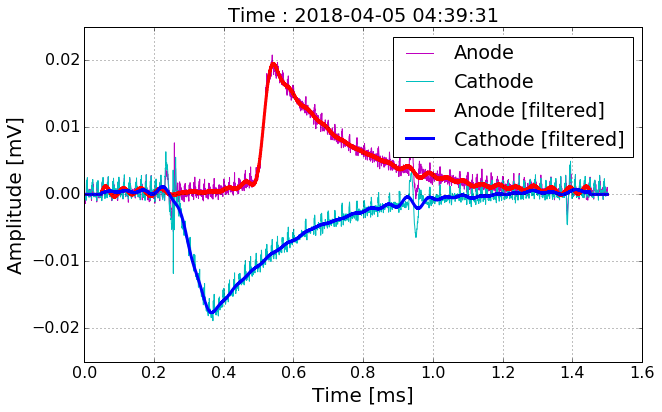

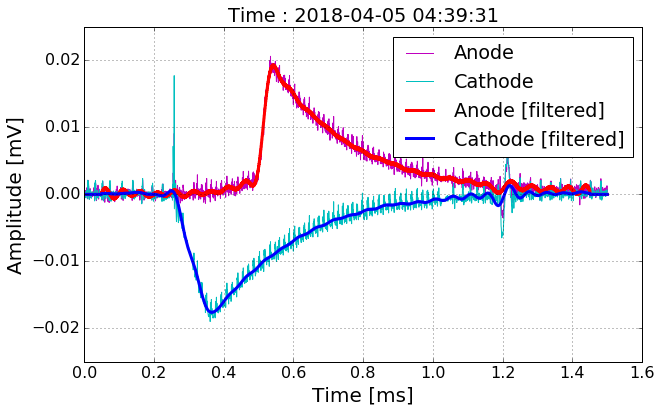

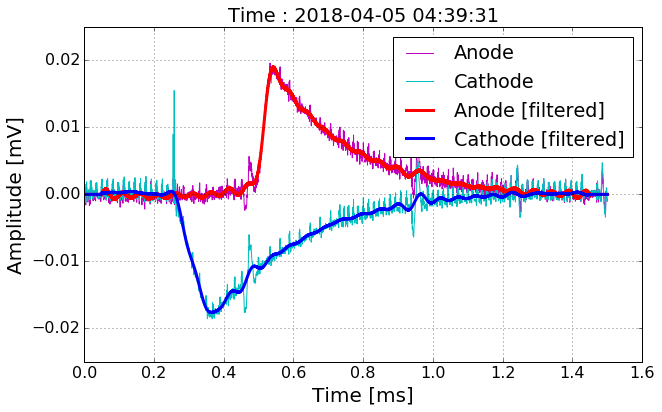

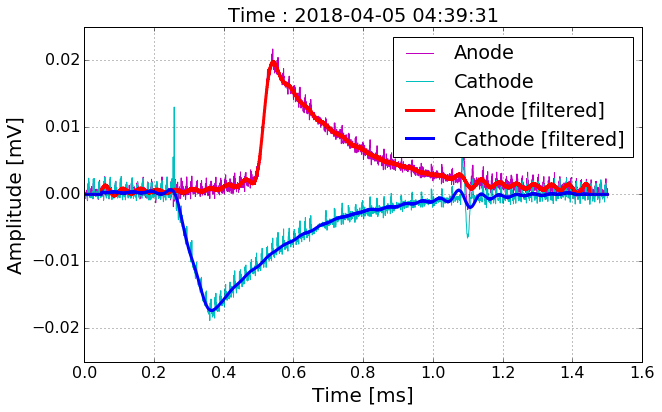

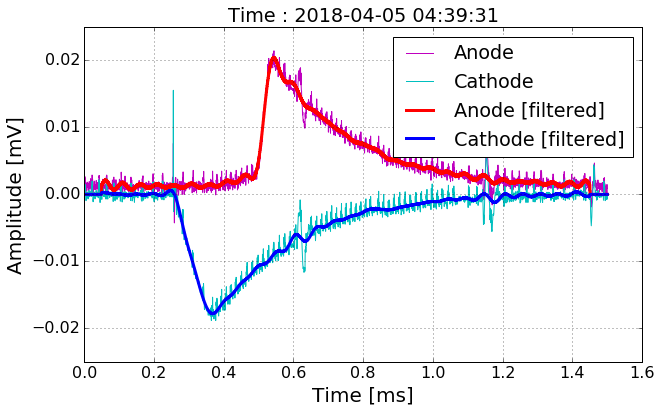

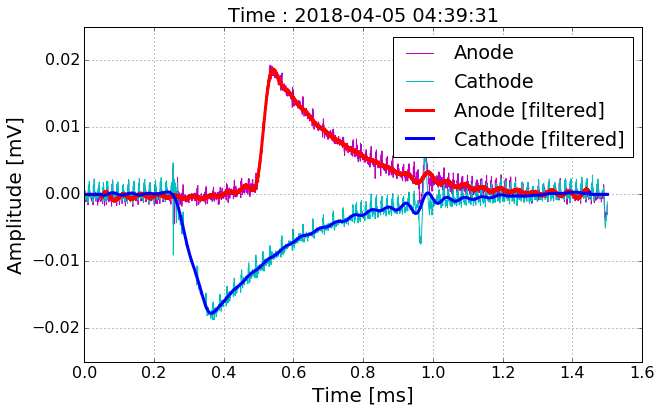

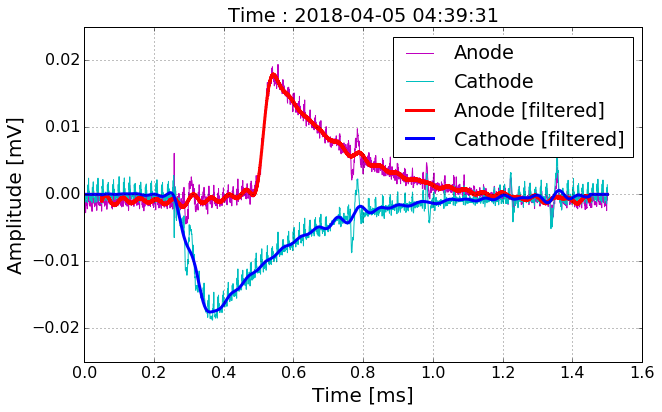

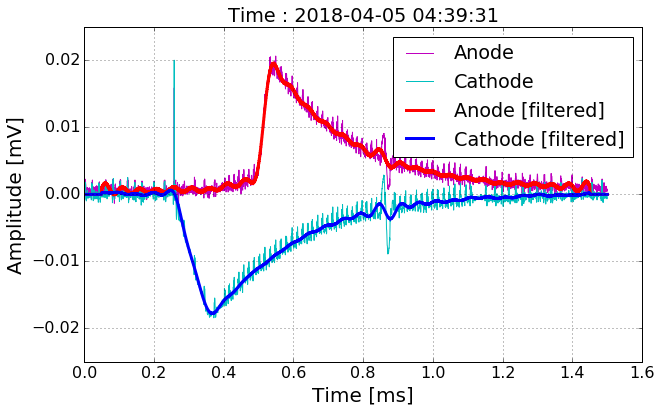

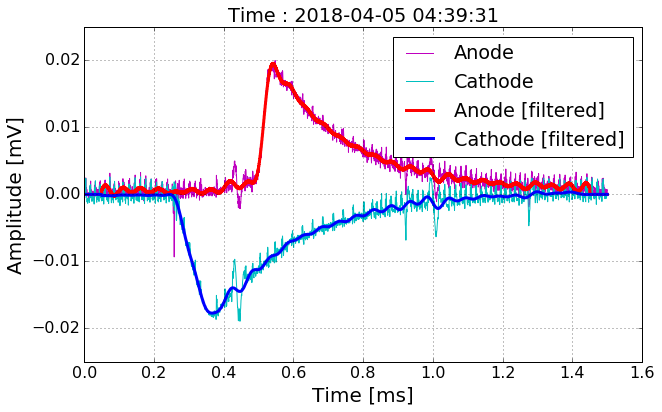

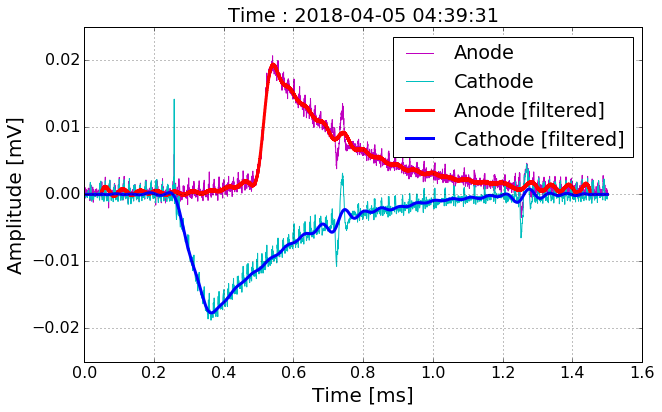

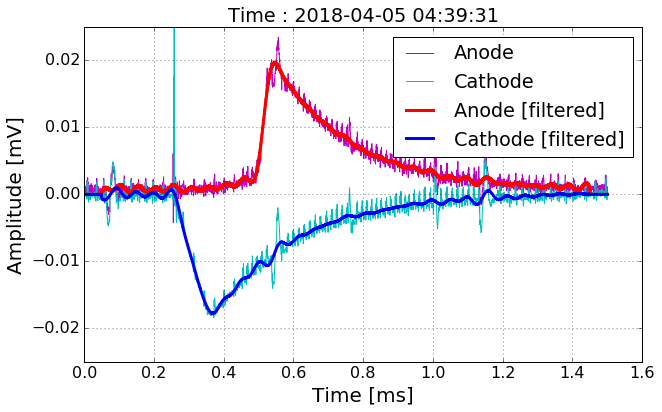

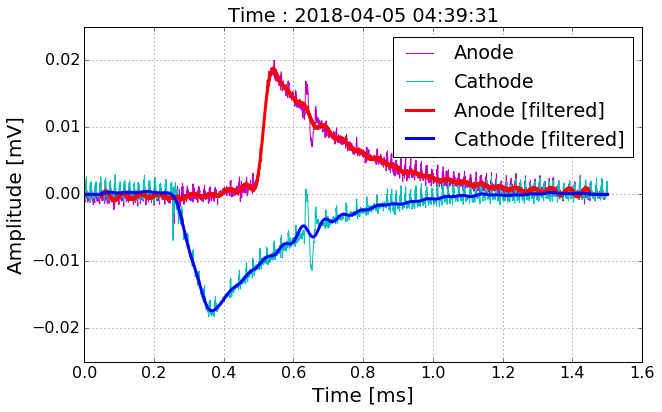

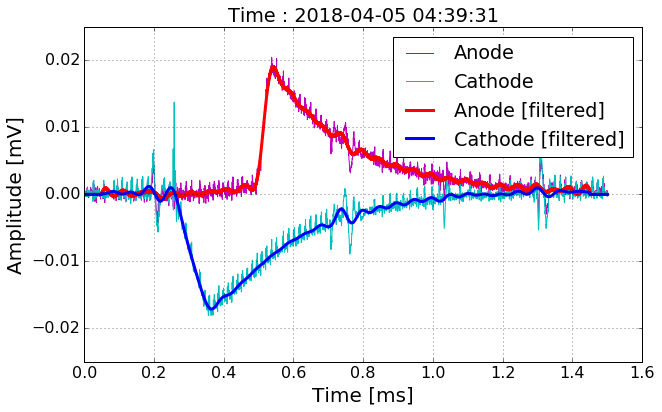

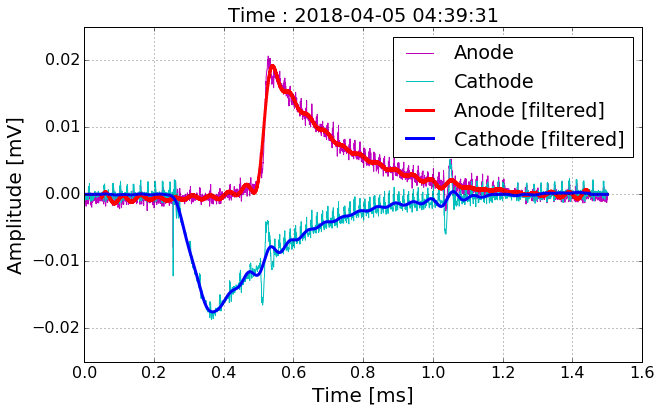

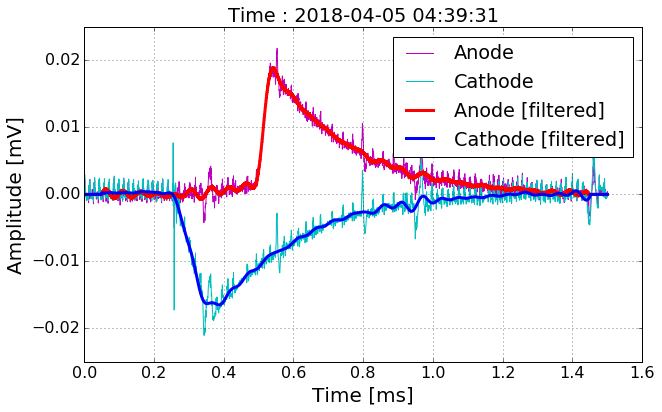

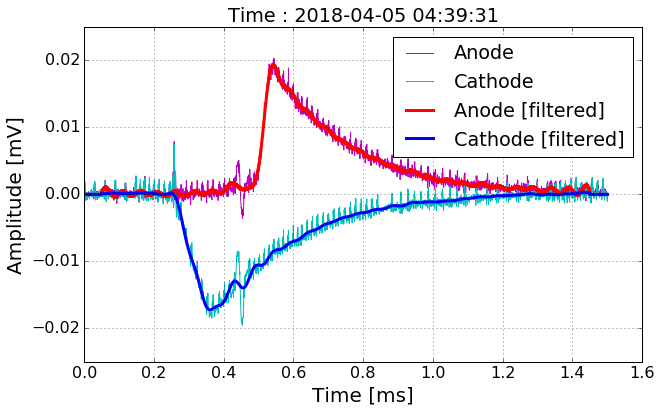

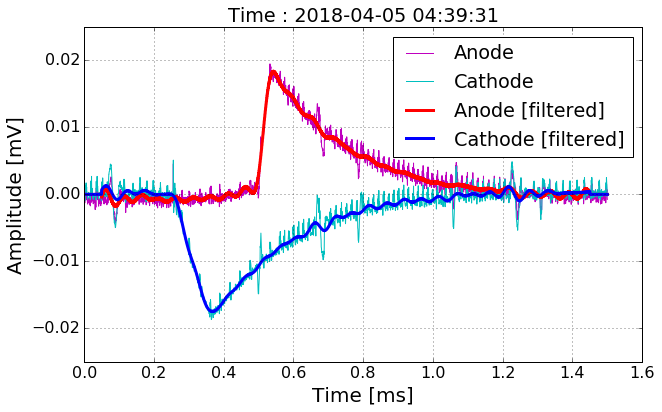

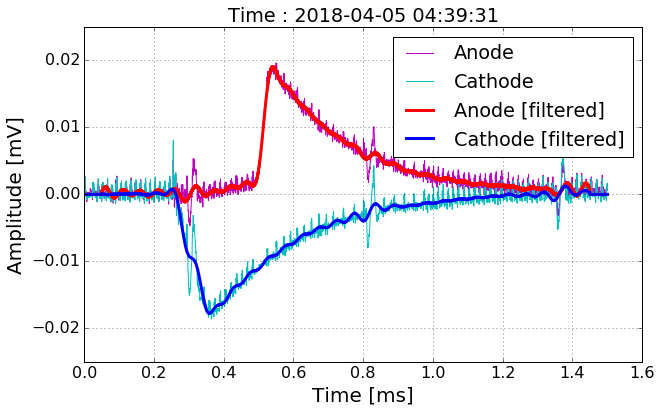

In [70]:
# simple noise filtering
# https://stackoverflow.com/questions/19122157/fft-bandpass-filter-in-python
wf_a = np.array(ev_wf_v[0][0][:3000])
wf_c = np.array(ev_wf_v[0][1][:3000])

for n in xrange(1,len(ev_wf_v)):
    
    anode_wf   = ev_wf_v[n][0]
    cathode_wf = ev_wf_v[n][1]
    # find start of this waveform
    anodestart = 0
    for i,V in enumerate(anode_wf):
        if (V > 0.02):
            anodestart = i
            break
    wf_a = anode_wf[anodestart:anodestart+3000]
    wf_c = cathode_wf[anodestart:anodestart+3000]

    freq_v = np.fft.fftfreq(len(wf_a),d=dt)

    time_v = np.linspace(0,dt*len(wf_a),len(wf_a))

    wf_a_freq_signl = np.fft.rfft(wf_a)
    wf_c_freq_signl = np.fft.rfft(wf_c)

    # cut freq. above 20 kHz
    wf_a_freq_signl[(freq_v > 20)] = 0
    wf_c_freq_signl[(freq_v > 20)] = 0

    wf_a_filtered = np.fft.irfft(wf_a_freq_signl)
    wf_c_filtered = np.fft.irfft(wf_c_freq_signl)
    
    wf_a_filtered[-100:] = 0
    wf_c_filtered[-100:] = 0    
    wf_a_filtered[:100] = 0
    wf_c_filtered[:100] = 0

    fig = plt.figure(figsize=(10,6))

    plt.plot(time_v,wf_a         ,color='m',label='Anode',lw=1)
    plt.plot(time_v,wf_c         ,color='c',label='Cathode',lw=1)

    plt.plot(time_v,wf_a_filtered,color='r',label='Anode [filtered]',lw=3)
    plt.plot(time_v,wf_c_filtered,color='b',label='Cathode [filtered]',lw=3)

    plt.grid()
    plt.legend(loc=1)
    plt.xlabel('Time [ms]',fontsize=20)
    plt.ylabel('Amplitude [mV]',fontsize=20)
    plt.title('Time : %s'%time)
    plt.ylim([-0.025,0.025])
    #plt.xlim([0,0.05])
    plt.show()